# RC Car Telemetry Anomaly Detection (Predictive Model)

## 목적
본 노트북은 RC Car에서 수집한 IMU 및 제어 명령 텔레메트리 데이터를 기반으로  
**정상 주행 시의 시간적 동역학을 학습하고**,  
이를 통해 **미래 센서 반응을 예측하지 못하는 상황을 이상(anomaly)**으로 탐지하는
**예측 기반 정상성 모델(Predictor)** 을 학습한다.

---

## 기존 AutoEncoder 접근의 한계
기존 AutoEncoder(AE)는 다음 구조를 가진다.

- 입력: 현재 센서 (+ cmd)
- 출력: 현재 센서 복원
- 이상 판단: 재구성 오차

이 접근은 다음과 같은 한계를 가진다.
- 정상 전진 주행은 동적 패턴이 복잡하여 오히려 재구성 오차가 커질 수 있음
- 전진 명령 중 차량이 멈춘(stuck) 상태는 IMU가 정적이어서 정상처럼 보일 수 있음
- 즉, **센서 파형의 “복원 난이도”가 이상 판단에 직접적으로 반영됨**

---

## 예측(Predictor) 기반 접근
본 노트북에서는 문제를 다음과 같이 재정의한다.

> “정상 상태에서는, 과거의 센서 및 제어 명령으로부터  
> 미래의 센서 반응을 예측할 수 있다.”

### Predictor 구조
- 입력 (X):
  - 과거 T_in 구간의 IMU 센서 (ax, ay, az, gx, gy, gz)
  - 과거 T_in 구간의 제어 명령 (throttle, steer)
- 출력 (Y):
  - 미래 T_out 구간의 IMU 센서 (또는 요약된 motion energy)

### 이상 판단 기준
- 정상: 미래 센서가 예측과 유사 → 예측 오차 낮음
- 이상:
  - 충격/기울어짐 → 예측 불가 → 오차 증가
  - 전진 명령 중 stuck → 움직임이 예측되었으나 실제는 정적 → 오차 증가

---

## 기대 효과
- 정상 전진 주행에서 anomaly score 과대 상승 문제 해결
- stuck(명령-응답 불일치) 상황에 대한 민감한 탐지
- 이상 라벨 없이 정상 데이터만으로 학습 가능
- 기존 AE 기반 파이프라인(윈도우링, 스케일링, threshold)을 그대로 재사용 가능

---

## 노트북 구성
1. 데이터 로딩 및 기본 설정
2. 시계열 윈도우 구성 (과거 → 미래)
3. 전처리 및 스케일링
4. Predictor 모델 정의
5. 학습 및 검증
6. 예측 오차 기반 anomaly score 산출
7. 실시간 추론 적용 가이드


## Time-series Prediction Setup

본 모델은 시계열 데이터를 다음과 같은 **예측 문제(prediction problem)** 로 정의한다.

---

### Sampling Rate
- 텔레메트리 수집 주기: **50 ms**
- Sampling rate: **20 Hz**

---

### Input / Output Window 정의

| 구분 | 기호 | 길이 | 시간 |
|---|---|---|---|
| 과거 입력 | T_in | 20 steps | 1.0 sec |
| 미래 예측 | T_out | 20 steps | 1.0 sec |
| 전체 윈도우 | T_total | 40 steps | 2.0 sec |

---

### 예측 문제 정의
- 입력 X:
  - 과거 T_in 구간의 센서 + 제어 명령
- 출력 Y:
  - 이후 T_out 구간의 센서 반응

즉, 모델은 다음을 학습한다.

> **“최근 1초간의 움직임과 명령을 보고,  
> 다음 1초 동안 차량의 센서 반응을 예측하라.”**

---

### 왜 이런 분할이 중요한가?

#### 1. 정상 전진 주행
- 과거 1초에 이미 진동/회전이 존재
- 미래 1초에도 유사한 패턴이 이어짐
- → 예측 가능 → 낮은 오차

#### 2. 전진 중 stuck
- 과거에는 전진 패턴이 있었음
- 그러나 미래에는 센서 변화가 급감
- → “움직일 거라 예측했는데 실제는 정적”
- → 예측 오차 급증 → anomaly

#### 3. 충격 / 전복 / 급격한 자세 변화
- 과거 패턴과 무관한 미래 파형
- → 예측 실패 → anomaly

---

### AE와의 결정적 차이
- AE: 현재 파형을 그대로 복원
- Predictor: **시간의 방향성을 학습**
- → 명령-응답 불일치(stuck)에 구조적으로 강함


In [ ]:
# =========================
# Time-series window config
# =========================

FS = 20               # Hz (50 ms sampling)
DT = 1.0 / FS         # seconds

T_IN = 20             # input steps (past)
T_OUT = 20            # prediction steps (future)
T_TOTAL = T_IN + T_OUT

print(f"Sampling rate: {FS} Hz")
print(f"Input window : {T_IN} steps ({T_IN*DT:.2f}s)")
print(f"Output window: {T_OUT} steps ({T_OUT*DT:.2f}s)")
print(f"Total window : {T_TOTAL} steps ({T_TOTAL*DT:.2f}s)")


Sampling rate: 20 Hz
Input window : 20 steps (1.00s)
Output window: 20 steps (1.00s)
Total window : 40 steps (2.00s)




## Building Past → Future Training Samples

본 셀에서는 연속적인 RC Car 텔레메트리 시계열 데이터를
**예측 기반 정상성 모델(Predictor)** 학습에 적합한
**(과거 → 미래)** 형태의 학습 샘플로 변환한다.

---

### Raw Telemetry Structure

각 CSV 파일은 다음과 같은 컬럼을 포함한다.

* Timestamp: `ts_ms`
* IMU Sensors: `ax, ay, az, gx, gy, gz`
* Control Commands: `throttle`, `steer`

이 중 `dist_cm`은 본 모델의 입력 및 출력에서 사용하지 않는다.

---

### Predictor Sample Definition

하나의 학습 샘플은 다음 두 부분으로 구성된다.

**입력 X (Past window)**

* 길이: `T_IN`
* 구성: 과거 IMU 센서 + 제어 명령
* Shape: `(T_IN, 8)`

**출력 Y (Future window)**

* 길이: `T_OUT`
* 구성: 이후 IMU 센서 반응만 사용
* Shape: `(T_OUT, 6)`

즉, 하나의 샘플은 다음과 같은 시간 구조를 가진다.

* 과거 구간: `t0` 부터 `t(T_IN-1)` 까지 → **X_past**
* 미래 구간: `t(T_IN)` 부터 `t(T_IN+T_OUT-1)` 까지 → **Y_future**

과거 센서와 명령을 보고, 그 이후의 센서 반응을 예측하는 문제로 정의된다.

---

### Sliding Window Sampling

* 하나의 CSV 파일에서 여러 개의 학습 샘플을 생성한다.
* 윈도우 시작 지점을 `stride` 간격으로 이동하며 샘플을 생성한다.
* 윈도우 내부에 timestamp gap이 큰 구간이 포함되면
  해당 샘플은 비연속 데이터로 판단하여 제외한다.

이를 통해:

* 서로 강하게 중복되지 않는 샘플을 확보하고
* 시계열 단절로 인한 학습 오류를 방지한다.

---

### Why Past → Future Matters

Predictor 모델은 단순히 센서를 복원하는 것이 아니라
**시간에 따른 차량 동역학을 학습**한다.

* 정상 전진 주행
  → 과거에 관측된 움직임이 미래에도 이어짐
  → 예측 가능 → 낮은 오차

* 전진 중 stuck
  → 과거에는 움직임이 있었으나
  미래에는 센서 변화가 거의 없음
  → 예측 실패 → 높은 오차

* 충격, 전복, 급격한 자세 변화
  → 과거 패턴과 무관한 미래 센서 파형
  → 예측 실패 → anomaly

---

### Summary

이 셀은 AutoEncoder 기반 접근을
**시간 예측 기반 접근(Predictor)** 으로 전환하는 핵심 단계이다.

이후의 모든 학습, 검증, anomaly score 계산은
본 셀에서 정의한 **(X_past, Y_future)** 구조를 기준으로 수행된다.

---

In [ ]:
import os
import glob
import pandas as pd
import numpy as np

# =========================
# Dataset configuration
# =========================

DATA_DIR = "/content/data"
CSV_FILES = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))

SENSOR_COLS = ["ax", "ay", "az", "gx", "gy", "gz"]
CMD_COLS = ["throttle", "steer"]
USE_COLS = SENSOR_COLS + CMD_COLS

STRIDE = 5            # 5 steps = 0.25 sec
MAX_GAP_MS = 150      # timestamp gap threshold

print(f"Found {len(CSV_FILES)} CSV files")
for f in CSV_FILES:
    print(" -", os.path.basename(f))


# =========================
# Helper: build samples from one dataframe
# =========================

def build_past_future_samples(df, t_in, t_out, stride, max_gap_ms):
    """
    df: pandas DataFrame sorted by ts_ms
    return:
      X: (N, T_IN, 8)  past sensor+cmd
      Y: (N, T_OUT, 6) future sensors only
    """
    X_list, Y_list = [], []

    ts = df["ts_ms"].values
    data = df[USE_COLS].values.astype(np.float32)

    N = len(df)
    total_len = t_in + t_out

    def dominant_ratio(x):
        vals, counts = np.unique(x, return_counts=True)
        return counts.max() / len(x)

    for start in range(0, N - total_len + 1, stride):
        end = start + total_len

        # timestamp continuity check
        ts_window = ts[start:end]
        if np.any(np.diff(ts_window) > max_gap_ms):
            continue

        window = data[start:end]

        # -------------------------------
        # cmd stability filter
        # -------------------------------
        cmd_win = window[:, 6:8]  # throttle, steer
        thr = cmd_win[:, 0]
        st  = cmd_win[:, 1]

        # 95% 이상 동일한 cmd만 허용
        if dominant_ratio(thr) < 0.95 or dominant_ratio(st) < 0.95:
            continue

        # split past / future
        x_past = window[:t_in]           # (T_IN, 8)
        y_future = window[t_in:]         # (T_OUT, 8)

        X_list.append(x_past)
        Y_list.append(y_future[:, :6])   # sensors only

    if len(X_list) == 0:
        return None, None

    return np.stack(X_list), np.stack(Y_list)


# =========================
# Build dataset (per-file + all)
# =========================

X_by_file = []
Y_by_file = []
file_names = []

for csv_path in CSV_FILES:
    df = pd.read_csv(csv_path)

    if "ts_ms" not in df.columns:
        print(f"Skip {os.path.basename(csv_path)} (missing ts_ms)")
        continue

    missing = [c for c in USE_COLS if c not in df.columns]
    if missing:
        print(f"Skip {os.path.basename(csv_path)} (missing {missing})")
        continue

    df = df.sort_values("ts_ms").reset_index(drop=True)

    X, Y = build_past_future_samples(
        df,
        t_in=T_IN,
        t_out=T_OUT,
        stride=STRIDE,
        max_gap_ms=MAX_GAP_MS
    )

    fname = os.path.basename(csv_path).replace(".csv", "")
    if X is None:
        print(f"[Warn] {fname}: no valid samples after filtering")
        continue

    X_by_file.append(X)
    Y_by_file.append(Y)
    file_names.append(fname)


# concat (debug / stats용)
X_all = np.concatenate(X_by_file, axis=0)
Y_all = np.concatenate(Y_by_file, axis=0)

print("\n[Per-file sample counts after cmd stability filter]")
for name, X in zip(file_names, X_by_file):
    print(f"- {name:18s}: {X.shape[0]:4d} samples")

print("\nTotal samples:")
print("X_all:", X_all.shape)   # (N, T_IN, 8)
print("Y_all:", Y_all.shape)   # (N, T_OUT, 6)


Found 9 CSV files
 - fwd_left.csv
 - fwd_right.csv
 - fwd_straight.csv
 - idle.csv
 - rev_left.csv
 - rev_right.csv
 - rev_straight.csv
 - steer_left_idle.csv
 - steer_right_idle.csv

[Per-file sample counts after cmd stability filter]
- fwd_left          :   40 samples
- fwd_right         :   40 samples
- fwd_straight      :   40 samples
- idle              :   80 samples
- rev_left          :   40 samples
- rev_right         :   40 samples
- rev_straight      :   40 samples
- steer_left_idle   :   30 samples
- steer_right_idle  :   30 samples

Total samples:
X_all: (380, 20, 8)
Y_all: (380, 20, 6)


## Train / Validation Split & Scaling Strategy

본 셀에서는 Predictor 학습을 위해 다음 3가지를 수행한다.

---

### 1) Data Leakage 방지
시계열 데이터는 인접한 윈도우들이 강하게 중복되므로,
샘플 단위 랜덤 split을 하면 train/val에 동일 구간이 섞여
검증 점수가 비정상적으로 좋아지는 leakage가 발생할 수 있다.

따라서 split은 다음 기준 중 하나로 수행해야 한다.

- (권장) CSV 파일 단위 split  
- 또는 clip 단위 split

본 노트북에서는 **CSV 파일 단위 split**을 사용한다.

---

### 2) Scaling 원칙 (Train-only fit)
스케일링은 반드시 train 데이터로만 fit하고,
val에는 동일 scaler를 적용한다.

- Sensors (ax~gz): StandardScaler (평균 0, 표준편차 1)
- Commands (throttle/steer): [-1, 1] 범위 스케일링

---

### 3) Predictor 입력/출력 스케일링 구조

- 입력 X_past:
  - sensor 6개 + cmd 2개 모두 사용
  - sensor: StandardScaler 적용
  - cmd: range scaling 적용

- 출력 Y_future:
  - sensor 6개만 예측 대상
  - 동일 StandardScaler 적용

즉, 모델은 "정규화된 미래 센서"를 예측하도록 학습된다.


In [ ]:
# ============================================
# Cell 4) Train/Val split (Option A) + Scaling
#  - Split: per-file time-block (keeps all modes in train)
#  - Scaling: sensor StandardScaler (fit on train only)
#            cmd range scaling to [-1, 1]
# ============================================

from sklearn.preprocessing import StandardScaler
import numpy as np

SEED = 42
np.random.seed(SEED)

# ---------------------------
# 1) Time-block split per file
#    (same scenario exists in both train/val, but different time segments)
# ---------------------------
VAL_RATIO = 0.2

X_train_list, Y_train_list = [], []
X_val_list,   Y_val_list   = [], []

split_report = []  # (name, n_total, n_train, n_val)

for name, Xf, Yf in zip(file_names, X_by_file, Y_by_file):
    n = Xf.shape[0]
    # 앞 80% train, 뒤 20% val
    cut = int(n * (1 - VAL_RATIO))
    cut = max(1, min(cut, n - 1))  # 최소 train 1개, val 1개 보장

    X_train_list.append(Xf[:cut])
    Y_train_list.append(Yf[:cut])

    X_val_list.append(Xf[cut:])
    Y_val_list.append(Yf[cut:])

    split_report.append((name, n, cut, n - cut))

X_train = np.concatenate(X_train_list, axis=0)
Y_train = np.concatenate(Y_train_list, axis=0)
X_val   = np.concatenate(X_val_list, axis=0)
Y_val   = np.concatenate(Y_val_list, axis=0)

print("[Split: per-file time-block]")
for name, n, n_tr, n_va in split_report:
    print(f"- {name:15s}: total={n:4d} | train={n_tr:4d} | val={n_va:4d}")
print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("X_val  :", X_val.shape,   "Y_val  :", Y_val.shape)


# ---------------------------
# 2) Scaling: sensors (train-only fit)
# ---------------------------
SENSOR_DIM = 6  # ax,ay,az,gx,gy,gz
sensor_scaler = StandardScaler()

# Fit scaler on TRAIN sensors from X (past)
X_train_sensor = X_train[:, :, :SENSOR_DIM].reshape(-1, SENSOR_DIM)
sensor_scaler.fit(X_train_sensor)

def scale_sensors_in_X(X):
    s = X[:, :, :SENSOR_DIM].reshape(-1, SENSOR_DIM)
    s_scaled = sensor_scaler.transform(s).reshape(X.shape[0], X.shape[1], SENSOR_DIM)
    return s_scaled

def scale_sensors_Y(Y):
    s = Y.reshape(-1, SENSOR_DIM)
    s_scaled = sensor_scaler.transform(s).reshape(Y.shape[0], Y.shape[1], SENSOR_DIM)
    return s_scaled


# ---------------------------
# 3) Scaling: commands (range scaling to [-1, 1])
# ---------------------------
THR_MIN, THR_MAX = -100.0, 100.0
STR_MIN, STR_MAX = -100.0, 100.0

def scale_cmd(cmd, lo, hi):
    return 2.0 * (cmd - lo) / (hi - lo) - 1.0

def scale_X(X):
    Xs = np.zeros_like(X, dtype=np.float32)

    # sensors -> StandardScaler
    Xs[:, :, :SENSOR_DIM] = scale_sensors_in_X(X).astype(np.float32)

    # cmd -> range scale
    thr = X[:, :, 6]
    st  = X[:, :, 7]
    Xs[:, :, 6] = scale_cmd(thr, THR_MIN, THR_MAX).astype(np.float32)
    Xs[:, :, 7] = scale_cmd(st,  STR_MIN, STR_MAX).astype(np.float32)

    return Xs


# ---------------------------
# 4) Apply scaling
# ---------------------------
X_train_s = scale_X(X_train)
X_val_s   = scale_X(X_val)

Y_train_s = scale_sensors_Y(Y_train).astype(np.float32)
Y_val_s   = scale_sensors_Y(Y_val).astype(np.float32)

print("\n[Scaled shapes]")
print("X_train_s:", X_train_s.shape, "Y_train_s:", Y_train_s.shape)
print("X_val_s  :", X_val_s.shape,   "Y_val_s  :", Y_val_s.shape)

print("\n[Scaled sensor stats - TRAIN (from X_train_s)]")
print("mean:", X_train_s[:, :, :SENSOR_DIM].mean(axis=(0, 1)))
print("std :", X_train_s[:, :, :SENSOR_DIM].std(axis=(0, 1)))

print("\n[Scaled cmd range - TRAIN (from X_train_s)]")
print("throttle min/max:", float(X_train_s[:, :, 6].min()), float(X_train_s[:, :, 6].max()))
print("steer    min/max:", float(X_train_s[:, :, 7].min()), float(X_train_s[:, :, 7].max()))


[Split: per-file time-block]
- fwd_left       : total=  40 | train=  32 | val=   8
- fwd_right      : total=  40 | train=  32 | val=   8
- fwd_straight   : total=  40 | train=  32 | val=   8
- idle           : total=  80 | train=  64 | val=  16
- rev_left       : total=  40 | train=  32 | val=   8
- rev_right      : total=  40 | train=  32 | val=   8
- rev_straight   : total=  40 | train=  32 | val=   8
- steer_left_idle: total=  30 | train=  24 | val=   6
- steer_right_idle: total=  30 | train=  24 | val=   6
X_train: (304, 20, 8) Y_train: (304, 20, 6)
X_val  : (76, 20, 8) Y_val  : (76, 20, 6)

[Scaled shapes]
X_train_s: (304, 20, 8) Y_train_s: (304, 20, 6)
X_val_s  : (76, 20, 8) Y_val_s  : (76, 20, 6)

[Scaled sensor stats - TRAIN (from X_train_s)]
mean: [-4.7115119e-08 -1.3528686e-09 -1.6097175e-08  1.2842448e-09
 -5.5849945e-08 -4.8262116e-08]
std : [0.99999994 1.0000001  0.9999999  0.9999999  0.9999998  0.9999998 ]

[Scaled cmd range - TRAIN (from X_train_s)]
throttle min/max: -0.

## Predictor Model (Past → Future)

본 셀에서는 AutoEncoder 대신 **Predictor(미래 예측 모델)** 를 정의한다.

---

### Input / Output

- 입력 X: 과거 `T_IN` 구간의 센서 + 명령  
  Shape: `(B, T_IN, 8)`  
  - 6 sensors: ax, ay, az, gx, gy, gz
  - 2 commands: throttle, steer

- 출력 Ŷ: 미래 `T_OUT` 구간의 센서 예측값  
  Shape: `(B, T_OUT, 6)`

즉 모델은 다음을 학습한다.

- "최근 1초(과거 20 step)의 상태와 명령을 보고,
  다음 1초(미래 20 step)의 IMU 센서 반응을 예측한다."

---

### Why Temporal Conv (1D CNN)?

본 노트북에서는 LSTM 대신 1D CNN 기반 Predictor를 사용한다.

- 파라미터 수가 상대적으로 적어 작은 데이터에서도 안정적
- 병렬 연산이 가능해 학습/추론 속도가 빠름
- 짧은 구간(1~2초)의 패턴 예측에 매우 적합

---

### Model Idea

- Encoder: `(B, T_IN, 8)` → `(B, hidden, T_IN)` 로 변환 후 Conv1D stack
- Head: 시간축을 `T_OUT`으로 매핑
- Output: `(B, T_OUT, 6)` (미래 센서)


In [ ]:
import torch
import torch.nn as nn

class ConvPredictor(nn.Module):
    """
    Past -> Future sensor predictor
    Input : (B, T_IN, 8)   (sensor6 + cmd2)
    Output: (B, T_OUT, 6)  (future sensors)
    """
    def __init__(self, t_in=20, t_out=20, in_dim=8, out_dim=6, hidden=64, k=3, dropout=0.1):
        super().__init__()
        self.t_in = t_in
        self.t_out = t_out

        # (B, T, C) -> (B, C, T) for Conv1d
        self.enc = nn.Sequential(
            nn.Conv1d(in_dim, hidden, kernel_size=k, padding=k//2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv1d(hidden, hidden, kernel_size=k, padding=k//2),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # Map time length T_IN -> T_OUT using a simple linear layer on the time axis
        # We do: (B, hidden, T_IN) -> (B, hidden, T_OUT)
        self.time_proj = nn.Linear(t_in, t_out)

        # Project hidden -> sensor dims at each time step
        # (B, hidden, T_OUT) -> (B, out_dim, T_OUT)
        self.head = nn.Conv1d(hidden, out_dim, kernel_size=1)

    def forward(self, x):
        # x: (B, T_IN, 8)
        x = x.transpose(1, 2)           # (B, 8, T_IN)
        h = self.enc(x)                 # (B, hidden, T_IN)
        h = self.time_proj(h)           # (B, hidden, T_OUT)  (Linear acts on last dim)
        y = self.head(h)                # (B, 6, T_OUT)
        y = y.transpose(1, 2)           # (B, T_OUT, 6)
        return y


# -------------------------
# Sanity check (shapes)
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvPredictor(t_in=T_IN, t_out=T_OUT, in_dim=8, out_dim=6, hidden=64).to(device)
print("Model created on:", device)

xb = torch.randn(4, T_IN, 8).to(device)
with torch.no_grad():
    yhat = model(xb)

print("Forward check:", "X", xb.shape, "-> Yhat", yhat.shape)


Model created on: cpu
Forward check: X torch.Size([4, 20, 8]) -> Yhat torch.Size([4, 20, 6])


## Dataset & DataLoader

본 셀에서는 전처리 및 스케일링이 완료된 데이터를
PyTorch 학습에 사용할 수 있도록 `Dataset`과 `DataLoader`로 구성한다.

---

### Dataset 구성

- 입력 X:
  - Shape: `(T_IN, 8)`
  - 과거 센서 + 제어 명령 (스케일링 완료)

- 출력 Y:
  - Shape: `(T_OUT, 6)`
  - 미래 센서 예측 대상 (스케일링 완료)

각 샘플은 하나의 `(X_past, Y_future)` 쌍으로 구성된다.

---

### DataLoader 구성

- Train:
  - shuffle = True
  - batch 단위로 무작위 섞어서 학습 안정성 확보

- Validation:
  - shuffle = False
  - 시간적 순서를 유지한 채 성능 평가

이 셀의 목적은 **배치 단위 shape이 모델과 정확히 맞는지 확인**하는 것이다.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# -------------------------
# PyTorch Dataset
# -------------------------
class TelemetryPredictorDataset(Dataset):
    def __init__(self, X, Y):
        """
        X: np.ndarray, shape (N, T_IN, 8)
        Y: np.ndarray, shape (N, T_OUT, 6)
        """
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# -------------------------
# Create datasets
# -------------------------
train_ds = TelemetryPredictorDataset(X_train_s, Y_train_s)
val_ds   = TelemetryPredictorDataset(X_val_s,   Y_val_s)

print("Train dataset size:", len(train_ds))
print("Val dataset size  :", len(val_ds))


# -------------------------
# DataLoaders
# -------------------------
BATCH_SIZE = 64

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

# -------------------------
# Sanity check (one batch)
# -------------------------
xb, yb = next(iter(train_loader))
print("Batch X:", xb.shape, "Batch Y:", yb.shape)
print("X dtype:", xb.dtype, "| Y dtype:", yb.dtype)


Train dataset size: 304
Val dataset size  : 76
Batch X: torch.Size([64, 20, 8]) Batch Y: torch.Size([64, 20, 6])
X dtype: torch.float32 | Y dtype: torch.float32


## Training the Predictor Model

본 셀에서는 Predictor 모델을 학습하고,
epoch별 train / validation loss를 통해 수렴 여부를 확인한다.

---

### Loss Function
- **MSELoss**
- 미래 센서 파형을 얼마나 정확히 예측했는지를 직접적으로 반영

---

### Optimizer
- **Adam**
- 작은 데이터셋에서도 안정적으로 수렴

---

### Validation 전략
- 매 epoch마다 validation loss를 계산
- 과적합 여부 및 일반화 성능을 확인

본 단계의 목표는
- train / val loss가 함께 감소하는지
- val loss가 일정 수준에서 안정화되는지
를 확인하는 것이다.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# -------------------------
# Training setup
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 40

print("Training on device:", device)


# -------------------------
# Train / Val loop
# -------------------------
train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train()
    running_train_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        yhat = model(xb)
        loss = criterion(yhat, yb)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * xb.size(0)

    train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # ---- Validation ----
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            yhat = model(xb)
            loss = criterion(yhat, yb)
            running_val_loss += loss.item() * xb.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # ---- Log ----
    print(
        f"[Epoch {epoch:03d}] "
        f"Train Loss: {train_loss:.6f} | "
        f"Val Loss: {val_loss:.6f}"
    )


Training on device: cpu
[Epoch 001] Train Loss: 0.587431 | Val Loss: 0.771933
[Epoch 002] Train Loss: 0.631077 | Val Loss: 0.771204
[Epoch 003] Train Loss: 0.598916 | Val Loss: 0.769872
[Epoch 004] Train Loss: 0.603239 | Val Loss: 0.769605
[Epoch 005] Train Loss: 0.595826 | Val Loss: 0.768908
[Epoch 006] Train Loss: 0.590403 | Val Loss: 0.768452
[Epoch 007] Train Loss: 0.585179 | Val Loss: 0.765714
[Epoch 008] Train Loss: 0.586862 | Val Loss: 0.765182
[Epoch 009] Train Loss: 0.596168 | Val Loss: 0.767436
[Epoch 010] Train Loss: 0.573256 | Val Loss: 0.766158
[Epoch 011] Train Loss: 0.590271 | Val Loss: 0.765762
[Epoch 012] Train Loss: 0.557411 | Val Loss: 0.765715
[Epoch 013] Train Loss: 0.588742 | Val Loss: 0.764785
[Epoch 014] Train Loss: 0.569816 | Val Loss: 0.763879
[Epoch 015] Train Loss: 0.579948 | Val Loss: 0.764362
[Epoch 016] Train Loss: 0.592433 | Val Loss: 0.765471
[Epoch 017] Train Loss: 0.592793 | Val Loss: 0.765355
[Epoch 018] Train Loss: 0.587228 | Val Loss: 0.765929
[Epo

## Anomaly Score from Prediction Error

Predictor 모델은 미래 센서 Ŷ를 예측한다.
정상 주행에서는 예측 오차가 작고, 이상 상황(충격/걸림/슬립 등)에서는 예측 오차가 커진다.

---

### Score 정의

- Per-step error:
  - 각 미래 step마다 6축 센서에 대한 MSE
  - shape: (T_OUT,)

- Window score (anomaly score):
  - Per-step error를 시간 축으로 평균낸 값
  - scalar 값 1개로 window의 이상 정도를 표현

---

### Threshold

정상 데이터(Train)의 window score 분포에서 percentile 기반 threshold를 정의한다.

- p95: 정상 중 상위 5% 수준
- p99: 정상 중 상위 1% 수준

실시간 적용 시에는 `score > threshold` 를 anomaly로 판단하는 기본 기준으로 사용할 수 있다.


[Window score stats]
Train mean/std: 0.6400445699691772 0.5578290224075317
Val   mean/std: 0.7657532095909119 0.7470583319664001
Thresholds (from TRAIN): p95 = 1.488857388496399 | p99 = 1.9811229705810547


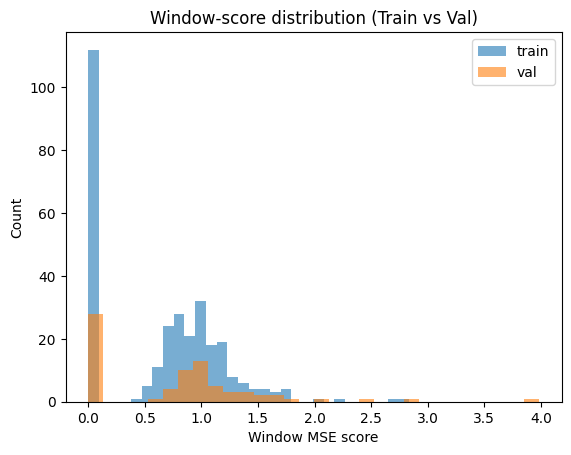

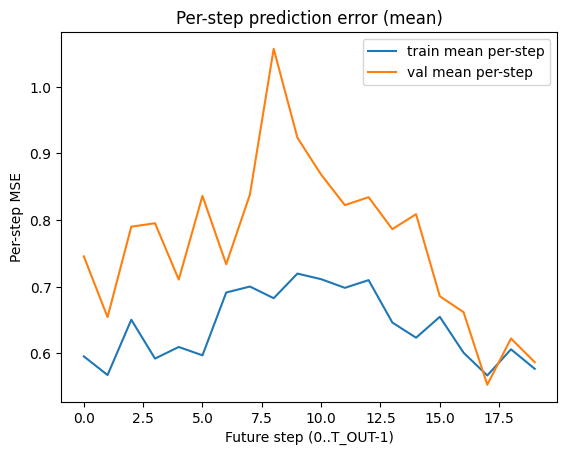


[Top VAL windows by score]
#1: idx=1 score=3.983976
#2: idx=4 score=2.827510
#3: idx=2 score=2.405303
#4: idx=3 score=2.047486
#5: idx=18 score=1.762564


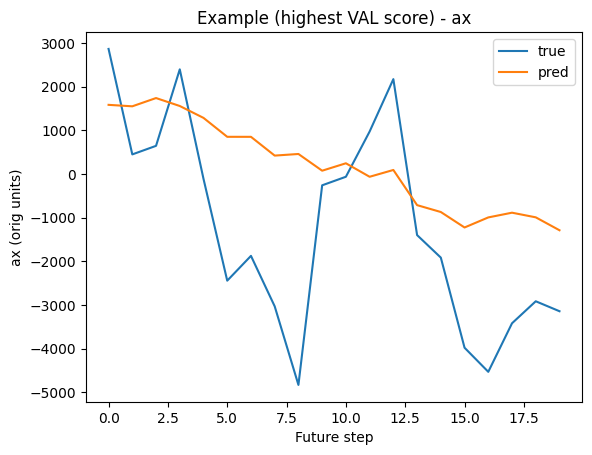

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# -------------------------
# Preconditions check
# -------------------------
required = ["model", "train_ds", "val_ds", "sensor_scaler", "T_OUT"]
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(
        f"Missing variables: {missing}\n"
        "Run previous cells (model training + dataset/scaler) first."
    )

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

train_loader_eval = DataLoader(train_ds, batch_size=128, shuffle=False, drop_last=False)
val_loader_eval   = DataLoader(val_ds,   batch_size=128, shuffle=False, drop_last=False)

def compute_scores(loader):
    """
    Returns:
      win_score: (N,) window-level score = mean over time of per-step MSE
      step_score: (N, T_OUT) per-step MSE (averaged over 6 sensor dims)
    """
    all_win = []
    all_step = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            yhat = model(xb)  # (B, T_OUT, 6)
            step_mse = ((yhat - yb) ** 2).mean(dim=2)   # (B, T_OUT)
            win_mse  = step_mse.mean(dim=1)             # (B,)

            all_step.append(step_mse.cpu().numpy())
            all_win.append(win_mse.cpu().numpy())

    return np.concatenate(all_win, axis=0), np.concatenate(all_step, axis=0)

train_win, train_step = compute_scores(train_loader_eval)
val_win, val_step     = compute_scores(val_loader_eval)

# -------------------------
# Thresholds from TRAIN
# -------------------------
p95 = float(np.percentile(train_win, 95))
p99 = float(np.percentile(train_win, 99))

print("[Window score stats]")
print("Train mean/std:", float(train_win.mean()), float(train_win.std()))
print("Val   mean/std:", float(val_win.mean()), float(val_win.std()))
print("Thresholds (from TRAIN): p95 =", p95, "| p99 =", p99)

# -------------------------
# Plot: score distributions
# -------------------------
plt.figure()
plt.hist(train_win, bins=30, alpha=0.6, label="train")
plt.hist(val_win, bins=30, alpha=0.6, label="val")
plt.xlabel("Window MSE score")
plt.ylabel("Count")
plt.title("Window-score distribution (Train vs Val)")
plt.legend()
plt.show()

# -------------------------
# Plot: mean per-step error curve
# -------------------------
plt.figure()
plt.plot(train_step.mean(axis=0), label="train mean per-step")
plt.plot(val_step.mean(axis=0), label="val mean per-step")
plt.xlabel("Future step (0..T_OUT-1)")
plt.ylabel("Per-step MSE")
plt.title("Per-step prediction error (mean)")
plt.legend()
plt.show()

# -------------------------
# Inspect top-k VAL windows
# -------------------------
topk = 5
idxs = np.argsort(-val_win)[:topk]
print("\n[Top VAL windows by score]")
for r, i in enumerate(idxs, 1):
    print(f"#{r}: idx={int(i)} score={float(val_win[i]):.6f}")

# -------------------------
# Visualize one example window (highest val score)
# - plot 1 axis in original units
# -------------------------
i0 = int(idxs[0])

# fetch scaled tensors
xb0 = torch.from_numpy(val_ds.X.numpy()[i0:i0+1]).float().to(device)  # (1, T_IN, 8) scaled
yb0 = torch.from_numpy(val_ds.Y.numpy()[i0:i0+1]).float().to(device)  # (1, T_OUT, 6) scaled

with torch.no_grad():
    yhat0 = model(xb0).cpu().numpy()[0]   # (T_OUT, 6) scaled
y0 = yb0.cpu().numpy()[0]                # (T_OUT, 6) scaled

# inverse scale to original units
y0_orig    = sensor_scaler.inverse_transform(y0)
yhat0_orig = sensor_scaler.inverse_transform(yhat0)

axis_names = ["ax","ay","az","gx","gy","gz"]
axis = 0  # 0=ax (원하면 바꿔도 됨)

plt.figure()
plt.plot(y0_orig[:, axis], label="true")
plt.plot(yhat0_orig[:, axis], label="pred")
plt.xlabel("Future step")
plt.ylabel(axis_names[axis] + " (orig units)")
plt.title(f"Example (highest VAL score) - {axis_names[axis]}")
plt.legend()
plt.show()


In [ ]:
# === Export artifacts for real-time inference ===
import os, json, joblib, torch

EXPORT_DIR = "/content/export"
os.makedirs(EXPORT_DIR, exist_ok=True)

# 1) model
MODEL_PATH = os.path.join(EXPORT_DIR, "best_predictor.pt")
torch.save(model.state_dict(), MODEL_PATH)

# 2) scaler
SCALER_PATH = os.path.join(EXPORT_DIR, "sensor_scaler.pkl")
joblib.dump(sensor_scaler, SCALER_PATH)

# 3) config (must match training)
cfg = {
    "T_IN": int(T_IN),
    "T_OUT": int(T_OUT),
    "feature_order_X": ["ax","ay","az","gx","gy","gz","throttle","steer"],
    "feature_order_Y": ["ax","ay","az","gx","gy","gz"],
    "cmd_scale": {"THR_MIN": -100.0, "THR_MAX": 100.0, "STR_MIN": -100.0, "STR_MAX": 100.0},
    "score": {"type": "window_mse_mean", "per_step_mse_dim_mean": True}
}
CFG_PATH = os.path.join(EXPORT_DIR, "config.json")
with open(CFG_PATH, "w") as f:
    json.dump(cfg, f, indent=2)

print("Saved:")
print(" -", MODEL_PATH)
print(" -", SCALER_PATH)
print(" -", CFG_PATH)


Saved:
 - /content/export/best_predictor.pt
 - /content/export/sensor_scaler.pkl
 - /content/export/config.json


In [ ]:
import torch

model.eval()
example = torch.zeros(1, T_IN, 8)   # (B,T_IN,FIN)
traced = torch.jit.trace(model.cpu(), example)

traced.save("/content/export/predictor_ts.pt")
print("saved /content/export/predictor_ts.pt")


saved /content/export/predictor_ts.pt
